# Piyush Kumar Gaurav
# AE-691: Optimal Control and Reinforcement Learning
## Project on "Covariance Steering"


## Required Libraries

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix,solvers

In [173]:
def create_timeinvar_Ak(dt):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    Ak = [[1, 0, dt, 0],[0, 1, 0, dt],[0, 0, 1, 0],[0, 0, 0, 1]]
    Ak = np.array(Ak)
    return Ak

def create_timeinvar_Bk(dt):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    Bk = [[0.5*dt*dt, 0],[0, 0.5*dt*dt],[dt, 0],[0, dt]]
    Bk = np.array(Bk)
    return Bk

def create_timeinvar_Dk(wt,dim):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    Dk = wt * np.identity(dim)
    return Dk

def create_timeinvar_AkBkDk_array(time_array, dt, Ak, Bk, Dk):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    no_instance = len(time_array)
    Ak_array = np.tile(Ak,(no_instance,1))
    Bk_array = np.tile(Bk,(no_instance,1))
    Dk_array = np.tile(Dk,(no_instance,1))
    return Ak_array, Bk_array, Dk_array

def create_timeinvar_Ahat_k(k,state_dim, Ak_array):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    Ahat_k = np.identity(state_dim)
    if k == 0 :
        return Ahat_k
    else:
        for i in range(0,k):
            A_tmp = Ak_array[i*state_dim:i*state_dim + state_dim,:]
            Ahat_k = np.dot(A_tmp,Ahat_k)
        return Ahat_k
    
def create_timeinvar_Ahat_k1_k0(k1, k0,state_dim, Ak_array):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    Ahat_k1_k0 = np.identity(state_dim)
    if k0 > k1:
        print("Error k0 should be less than k1")
        return Ahat_k1_k0
    elif k0 == 0 and k1 == 0:
        return Ahat_k1_k0
    elif k0 == 0 and k1 > 0:
        for i in range(0,k1+1):
            A_tmp = Ak_array[i*state_dim:i*state_dim + state_dim,:]
            Ahat_k1_k0 = np.dot(A_tmp,Ahat_k1_k0)
        return Ahat_k1_k0
    else:
        for i in range(k0,k1+1):
            A_tmp = Ak_array[i*state_dim:i*state_dim + state_dim,:]
            Ahat_k1_k0 = np.dot(A_tmp,Ahat_k1_k0)
        return Ahat_k1_k0

def extract_Bk_mat(k, state_dim, Bk_array):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    Bk_mat = Bk_array[k*state_dim:k*state_dim + state_dim,:]
    return Bk_mat

def create_timeinvar_Bhat_k1_k0(k1, k0,state_dim, Ak_array, Bk_array):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    B_k0 = Bk_array[k0*state_dim:k0*state_dim + state_dim,:]
    A_term = create_timeinvar_Ahat_k1_k0(k1, k0+1,state_dim, Ak_array)
    Bhat_k1_k0 = np.dot(A_term,B_k0)
    return Bhat_k1_k0
    

def create_timeinvar_Dhat_k1_k0(k1, k0,state_dim, Ak_array, Dk_array):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    D_k0 = Dk_array[k0*state_dim:k0*state_dim + state_dim,:]
    A_term = create_timeinvar_Ahat_k1_k0(k1, k0+1,state_dim, Ak_array)
    Dhat_k1_k0 = np.dot(A_term,D_k0)
    return Dhat_k1_k0

def create_timeinvar_augA(state_dim, Ak_array):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    augA = np.identity(state_dim)
#     time_array = np.append(time_array, [tf])
#     no_instance = len(time_array)
#     Ak_array = np.tile(Ak,(no_instance,1))
    
    for i in range(1,N+1):
        Ahat_k = create_timeinvar_Ahat_k(i,state_dim, Ak_array)
        augA = np.block([[augA],[Ahat_k]])
    return augA

def create_timeinvar_augB(N, state_dim, u_dim, Ak_array, Bk_array):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    first_row = np.zeros((state_dim, N*u_dim))
    augB = np.zeros((N*state_dim, N*u_dim))
    for i in range(N):
        for j in range(N):
            if i==j:
                augB[i*state_dim:i*state_dim+state_dim, j*u_dim: j*u_dim+u_dim] = extract_Bk_mat(i, state_dim, Bk_array)
            elif i>=j:
                augB[i*state_dim:i*state_dim+state_dim, j*u_dim: j*u_dim+u_dim] = create_timeinvar_Bhat_k1_k0(i, j,state_dim, Ak_array, Bk_array)
            else:
                pass
    augB = np.concatenate((first_row, augB), axis=0)
    return augB

    
    
def create_timeinvar_augD(N, state_dim, noise_dim, Ak_array, Dk_array):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    first_row = np.zeros((state_dim, N*noise_dim))
    augD = np.zeros((N*state_dim, N*noise_dim))
    for i in range(N):
        for j in range(N):
            if i==j:
                augD[i*state_dim:i*state_dim+state_dim, j*noise_dim: j*noise_dim+noise_dim] = extract_Bk_mat(i, state_dim, Dk_array) # extract_Bk_mat remains same
            elif i>=j:
                augD[i*state_dim:i*state_dim+state_dim, j*noise_dim: j*noise_dim+noise_dim] = create_timeinvar_Bhat_k1_k0(i, j,state_dim, Ak_array, Dk_array)
            else:
                pass
    augD = np.concatenate((first_row, augD), axis=0)
    return augD

def create_timeinvar_augQ(N,Qk):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    Q = Qk
    n_rows = Qk.shape[0]
    n_cols = Qk.shape[1]
    n_rows_Q = n_rows
    n_cols_Q = n_cols
    for i in range(N-1):
        Q = np.block([[Q, np.zeros((n_rows_Q, n_cols))],[np.zeros((n_rows, n_cols_Q)), Qk]])
        n_rows_Q = Q.shape[0]
        n_cols_Q = Q.shape[1]
    Q = np.block([[Q, np.zeros((n_rows_Q, n_cols))],[np.zeros((n_rows, n_cols_Q)), np.zeros((n_rows, n_cols))]])
    return Q

def create_timeinvar_augR(N,Rk):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    R = Rk
    n_rows = Rk.shape[0]
    n_cols = Rk.shape[1]
    n_rows_R = n_rows
    n_cols_R = n_cols
    for i in range(N-1):
        R = np.block([[R, np.zeros((n_rows_R, n_cols))],[np.zeros((n_rows, n_cols_R)), Rk]])
        n_rows_R = R.shape[0]
        n_cols_R = R.shape[1]
    return R

def select_kplus1th(k,block_dim, AB):
    ''' 
    This fn is a part of data preprocessing. This fn. does following:
    1. Removes the column which seeems logically irrelevant (least relevant) for price estimation 
    
    input: df -> panda dataframe
    output: df - panda dataframe (after processing)
    '''
    n_rows = AB.shape[0]
    n_cols = AB.shape[1]
    
    AB_k = AB[k*block_dim:k*block_dim+block_dim,:]
    return AB_k

In [226]:
################ MEAN STEERING ################
dt = 0.2
t0 = 0.0
tf = 10.0
wt = 0.01
dim = 4
time_array = np.arange(t0, tf, dt)
N = len(time_array)
state_dim = 4
u_dim = 2
noise_dim = 4
Qk = np.diag([0.05, 0.05, 0.05, 0.05])
Rk = np.diag([20, 20])

mu_0 = np.array([[-10.0, 1.0, 0.0, 0.0]]).T
mu_N = np.array([[0, 0, 0, 0]]).T

Ak = create_timeinvar_Ak(dt)
Bk = create_timeinvar_Bk(dt)
Dk = create_timeinvar_Dk(wt, dim)
Ak_array, Bk_array, Dk_array = create_timeinvar_AkBkDk_array(time_array, dt,Ak, Bk, Dk)

augA = create_timeinvar_augA(state_dim, Ak_array)
augB = create_timeinvar_augB(N, state_dim, u_dim, Ak_array, Bk_array)
augD = create_timeinvar_augD(N, state_dim, noise_dim, Ak_array, Dk_array)
augQ = create_timeinvar_augQ(N,Qk)
augR = create_timeinvar_augR(N,Rk)

augA_N = select_kplus1th(N,state_dim, augA)
augB_N = select_kplus1th(N,state_dim, augB)

R_new = augB.T @ augQ @ augB + augR
R_new_inv = np.linalg.inv(R_new)

V_T3 = mu_N - (augA_N @ mu_0) - (augB_N @ R_new_inv @ augB.T @ augQ @ augA @ mu_0)
V_T2 = augB_N.T @ np.linalg.inv(augB_N @ R_new_inv @ augB_N.T)
V_T1 = augB.T @ augQ @ augA @ mu_0

U_mean = R_new_inv @ (V_T1 + V_T2 @ V_T3)

In [227]:
print("Shape of augA", augA.shape)
print("Shape of augB", augB.shape)
print("Shape of augD", augD.shape)
print("Shape of augQ", augQ.shape)
print("Shape of augR", augR.shape)

Shape of augA (204, 4)
Shape of augB (204, 100)
Shape of augD (204, 200)
Shape of augQ (204, 204)
Shape of augR (100, 100)


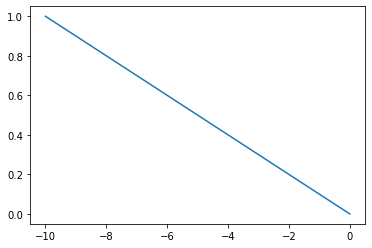

In [228]:
# Generating states per Mean Dynamics
x_kplus1 = np.zeros((state_dim*(N+1),1))
x_arr = []
y_arr = []
for i in range(N+1):
    augA_k = select_kplus1th(i,state_dim, augA)
    U_mean_k = select_kplus1th(i,state_dim, augB@U_mean)
    x_kplus1[i*state_dim:i*state_dim+state_dim, :] = augA_k @ mu_0 + U_mean_k 
    x_arr.append(x_kplus1[i*state_dim, 0])
    y_arr.append(x_kplus1[i*state_dim+1, 0])
x_arr = np.array(x_arr)
y_arr = np.array(y_arr)
plt.plot(x_arr, y_arr)

In [117]:
######## CVXOPT TUTORIAL ########

# Matrix (A) to np-array (B) to Matrix (C)
A = matrix([[1,2,3],[4,5,6]]) # Matrix defined
B = np.array(A) # matrix converted to np-array 
C = matrix(B) # np-array converted to matrix

In [125]:
######## CVXOPT TUTORIAL ########

# Solving a linear program
A = matrix([ [-1.0, -1.0, 0.0, 1.0], [1.0, -1.0, -1.0, -2.0] ])
b = matrix([ 1.0, -2.0, 0.0, 4.0 ])
c = matrix([ 2.0, 1.0 ])
sol=solvers.lp(c,A,b)
print(sol['x'])

     pcost       dcost       gap    pres   dres   k/t
 0:  2.6471e+00 -7.0588e-01  2e+01  8e-01  2e+00  1e+00
 1:  3.0726e+00  2.8437e+00  1e+00  1e-01  2e-01  3e-01
 2:  2.4891e+00  2.4808e+00  1e-01  1e-02  2e-02  5e-02
 3:  2.4999e+00  2.4998e+00  1e-03  1e-04  2e-04  5e-04
 4:  2.5000e+00  2.5000e+00  1e-05  1e-06  2e-06  5e-06
 5:  2.5000e+00  2.5000e+00  1e-07  1e-08  2e-08  5e-08
Optimal solution found.
[ 5.00e-01]
[ 1.50e+00]



In [126]:
######## CVXOPT TUTORIAL ########

# Solving a quadratic program
Q = 2*matrix([ [2, .5], [.5, 1] ])
p = matrix([1.0, 1.0])
G = matrix([[-1.0,0.0],[0.0,-1.0]])
h = matrix([0.0,0.0])
A = matrix([1.0, 1.0], (1,2))
b = matrix(1.0)
sol=solvers.qp(Q, p, G, h, A, b)
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  1.8889e+00  7.7778e-01  1e+00  2e-16  2e+00
 1:  1.8769e+00  1.8320e+00  4e-02  2e-16  6e-02
 2:  1.8750e+00  1.8739e+00  1e-03  2e-16  5e-04
 3:  1.8750e+00  1.8750e+00  1e-05  1e-16  5e-06
 4:  1.8750e+00  1.8750e+00  1e-07  1e-16  5e-08
Optimal solution found.
[ 2.50e-01]
[ 7.50e-01]

